# VBF and ggF discrimination

**Goal:** See if you can build a simple Deep Sets algorithm to do VBF vs ggF discrimination.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

import json
import time
import h5py

import os
os.sys.path.append('../code')
from preprocess import scale

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import dask
import dask.array as da

%load_ext autoreload
%autoreload 2

In [2]:
from analysis import triggers

with open("../code/hashMap.json", 'r') as varfile:
    hashMap = json.load(varfile)
triggerHashes = { year : [ hashMap[ti] for ti in triggers[year] ] for year in [2015,2016,2017,2018] }


**Step 1:** Data preprocessing

In [4]:
# Load file

ggf_filename = "../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root"
vbf_filename = "../../public/hh4b/SMNR/user.jagrundy.HH4B.450052.VBF_nonres.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736311._000001.MiniNTuple.root"

treename = "XhhMiniNtuple" 

f = uproot.open(vbf_filename)
tree = f[treename]

In [7]:
tree.array(b'truth_pdgId')

<JaggedArray [[25 -5 25 -5 5 5] [5 25 5 -5 -5 25] [25 -5 25 5 5 -5] ... [-5 5 25 25 5 -5] [5 -5 5 25 25 -5] [5 -5 25 25 -5 5]] at 0x7f0d9e0a9450>

In [9]:
for k in tree.keys():
    if 'Lab' in k.decode():
        print(k)

b'resolvedJets_HadronConeExclTruthLabelID'
b'resolvedJets_HadronConeExclExtendedTruthLabelID'
b'boostedTrkJets_HadronConeExclTruthLabelID'
b'boostedTrkJets_HadronConeExclExtendedTruthLabelID'


In [5]:
def processDf(filename,treename="XhhMiniNtuple",nJetsMax=8,nTagMin=4,year=2016):
    '''
    Given an input MNT, get the relevant jet features and apply the ml preprocessing
    
    Inputs:
    - filename
    - treename
    - nJetsMax
    - nTagMin
    - year: Year to apply the corresponding triggers for (default 2016)
    
    Returns:
    
    '''
    
    # Open the file
    print(f"\nOpening {filename}")
    f = uproot.open(filename)
    tree = f[treename]

    print('Loading in the event df')
    evt_vars = ['eventNumber', 'nresolvedJets','resolved_nBTags', 'mcEventWeight','weight_pileup','rand_run_nr']
    df = tree.pandas.df(evt_vars)
    
    # Get the jets
    pre = 'resolvedJets'
    jet_vars = [f'{pre}_{v}' for v in ['E','pt','phi','eta','is_DL1r_FixedCutBEff_77','Quantile_DL1r_Continuous','SF_DL1r_Continuous']]
    jVars = ['pt','eta','phi','E','Db','sf']
    myCols = [f'j{i}_{v}' for i in range(nJetsMax) for v in jVars]
    for c in myCols:
        df[c] = 0
    
    print('Loading in the jet array')
    arr = tree.arrays(jet_vars)
    
    for njet in range(4,np.max(df.nresolvedJets)):
    
        mask = df['nresolvedJets'] == njet
        if np.sum(mask) == 0:
            continue
        
        for v,w in zip(jVars[:5], jVars[:4]+['Quantile_DL1r_Continuous']):
            k = f'resolvedJets_{w}'.encode()

            if njet <= nJetsMax:
                df.loc[mask,[f'j{i}_{v}' for i in range(njet)]] = arr[k][mask].flatten().reshape(-1,njet)
            else:
                df.loc[mask,[f'j{i}_{v}' for i in range(nJetsMax)]] = arr[k][mask].flatten().reshape(-1,njet)[:,:nJetsMax]
        
        print(f'  Jet sfs for evts with {njet} jets')
        sf_arr = np.array([[ci[0] for ci in c] for c in arr[f'{pre}_SF_DL1r_Continuous'.encode()][mask]])
        N = min(njet, nJetsMax)
        df.loc[mask,[f'j{i}_sf'  for i in range(N)]] = sf_arr if N < nJetsMax else sf_arr[:,:N] 
        
    # Get the analysis trigger decision
    print(f'Applying {year} triggers')
    passedTriggerHashes = tree.array(b'passedTriggerHashes')

    for ti in triggers[year]:
        df[ti] = (passedTriggerHashes == hashMap[ti]).sum().astype(bool)

    df['trigger'] = df[triggers[year]].sum(axis=1).astype(bool)
    
    # Calculate the mcEvent Weight
    sfs = df[[f'j{i}_sf' for i in range(nJetsMax)]].values
    sfs = np.where(sfs==0, 1, sfs)
    sfs = np.prod(sfs,axis=1)
    df['mc_sf'] = df['mcEventWeight'] * df['weight_pileup'] * sfs
              
    # Apply 4 jets, b-tagger cuts
    df['ntag'] = np.sum(df[[f'j{i}_Db' for i in range(nJetsMax)]] >= 3,axis=1)
    
    preSel = df['trigger'] & (df['nresolvedJets'] >= 4) & (df['ntag'] >= 4)
    return df[preSel]

In [6]:
ggf = processDf(ggf_filename)
vbf = processDf(vbf_filename)


Opening ../../public/hh4b/SMNR/user.jagrundy.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736236._000001.MiniNTuple.root
Loading in the event df
Loading in the jet array
  Jet sfs for evts with 4 jets
  Jet sfs for evts with 5 jets
  Jet sfs for evts with 6 jets
  Jet sfs for evts with 7 jets
  Jet sfs for evts with 8 jets
  Jet sfs for evts with 9 jets
  Jet sfs for evts with 10 jets
  Jet sfs for evts with 11 jets
  Jet sfs for evts with 12 jets
  Jet sfs for evts with 13 jets
  Jet sfs for evts with 14 jets
  Jet sfs for evts with 15 jets
  Jet sfs for evts with 17 jets
Applying 2016 triggers

Opening ../../public/hh4b/SMNR/user.jagrundy.HH4B.450052.VBF_nonres.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736311._000001.MiniNTuple.root
Loading in the event df
Loading in the jet array
  Jet sfs for evts with 4 jets
  Jet sfs for evts with 5 jets
  Jet sfs for evts with 6 jets
  Jet sfs for evts with 7 jets
  Jet sf

I guess the VBF file is a lot smaller?

In [7]:
len(ggf.index)

125769

In [8]:
len(vbf.index)

6349

In [9]:
len(ggf.index) / len(vbf.index)

19.809261300992283

In [10]:
from preprocess import scale

In [11]:
myCols = [f'j{i}_{v}' for i in range(8) for v in ['pt','eta','phi','E','Db']]
    
vbf[myCols]

j0_pt    j0_eta    j0_phi         j0_E  j0_Db       j1_pt  \
entry                                                                   
6      223.952927 -0.483825  3.083440   251.057190      5  158.781265   
8      149.171249  1.749129 -2.356351   441.901672      1  149.479340   
15     158.797821  0.254473  2.643839   164.557114      5  141.081406   
35     227.124527 -1.148868 -0.421789   394.625305      5   84.773010   
41     132.980911  2.776507  2.212450  1072.241333     -1  123.158920   
...           ...       ...       ...          ...    ...         ...   
74229  117.561386  2.088395 -2.234215   481.848206      2  100.821053   
74239  114.461342 -2.032688  1.607512   444.558960      1  104.867432   
74248   79.663536  0.442707 -2.046345    88.655098      4   74.778351   
74257  229.409775 -0.918662 -2.022325   334.027802      5  185.466690   
74265  138.513580  0.083262 -0.681112   139.447296      5  117.143059   

         j1_eta    j1_phi        j1_E  j1_Db  ...      j6_pt    j6_eta  \
entry                                         ...                        
6     -0.263918  0.745022  164.836700      4  ...  32.703339  4.165390   
8      0.980532  1.808819  227.605865      5  ...  27.122099  2.933816   
15     2.208606 -0.793000  649.995300      1  ...   0.000000  0.000000   
35    -0.667046  1.647904  105.122917      5  ...   0.000000  0.000000   
41    -1.518007  1.780585  294.670746      1  ...   0.000000  0.000000   
...         ...       ...         ...    ...  ...        ...       ...   
74229 -0.160304  1.131538  102.836250      5  ...   0.000000  0.000000   
74239 -1.192070 -1.991573  188.804871      4  ...  34.265404  0.685589   
74248 -0.049813 -0.048591   75.472153      5  ...   0.000000  0.000000   
74257  0.381643  1.343337  199.691864      5  ...   0.000000  0.000000   
74265 -0.116836 -1.501360  119.155754      3  ...   0.000000  0.000000   

         j6_phi         j6_E  j6_Db     j7_pt    j7_eta    j7_phi        j7_E  \
entry                                                                           
6     -1.109525  1053.591919     -1  27.58087  4.101368  2.583004  833.486084   
8     -1.481189   255.714096     -1   0.00000  0.000000  0.000000    0.000000   
15     0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
35     0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
41     0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
...         ...          ...    ...       ...       ...       ...         ...   
74229  0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
74239  1.918077    43.242157      5   0.00000  0.000000  0.000000    0.000000   
74248  0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
74257  0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   
74265  0.000000     0.000000      0   0.00000  0.000000  0.000000    0.000000   

       j7_Db  
entry         
6         -1  
8          0  
15         0  
35         0  
41         0  
...      ...  
74229      0  
74239      0  
74248      0  
74257      0  
74265      0  

[6349 rows x 40 columns]

In [12]:
xi = vbf[myCols].values.reshape(-1,8,5)

In [13]:
xi[0,0,:]

array([223.95292664,  -0.483825  ,   3.0834403 , 251.05718994,
         5.        ])

In [14]:
xi[1,1,:]

array([149.4793396 ,   0.98053229,   1.8088187 , 227.60586548,
         5.        ])

In [15]:
def mlPreprocess(df1,df2,nJetsMax=8):
    '''
    Apply the preprocessing
    
    df1: Signal events
    df2: Bkg events
    
    '''

    jVars = ['pt','eta','phi','E','Db']
    myCols = [f'j{i}_{v}' for i in range(nJetsMax) for v in jVars]
    nFeatures = len(jVars)
        
    X1 = df1[myCols].values.reshape(-1, nJetsMax, nFeatures)
    X2 = df2[myCols].values.reshape(-1, nJetsMax, nFeatures)
    
    X = np.vstack((X1,X2))
    y = np.concatenate((np.ones(len(df1.index)),np.zeros(len(df2.index))))
    w = np.concatenate((df1.mc_sf, df2.mc_sf))
    evtNbr = np.concatenate((df1.eventNumber, df2.eventNumber))
    
    
    # Get training weights - i.e, reweight the truth mhh histograms?
    
    # Preprocessing
    mask = ~ np.sum(X==0, axis=-1).astype(bool)
    
    scale(X, mask, range(nFeatures), jVars, 'vbf_vs_ggf.json')
    
    # Train test split - split by mcEventNumber
    # even: train
    # 1: test
    even = (evtNbr % 2 == 0)
    odd  = (evtNbr % 2 == 1)
    X_tr, X_te = X[even], X[odd]
    y_tr, y_te = y[even], y[odd]
    w_tr, w_te = w[even], w[odd]
    
    return X_tr, X_te, y_tr, y_te, w_tr, w_te

In [16]:
ggf.j7_Db.min(),ggf.j7_Db.max()

(-1, 5)

(array([  4910., 107218.,   9937.,    352.,    547.,    552.,   2253.]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 7 Patch objects>)

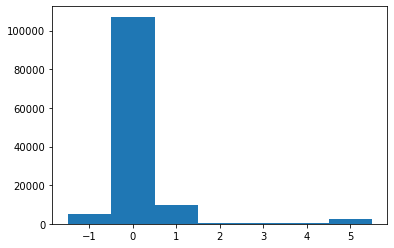

In [17]:
plt.hist(ggf.j7_Db,7,(-1.5,5.5))

In [18]:
X_tr, X_te, y_tr, y_te, w_tr, w_te = mlPreprocess(ggf,vbf)

Scaling pt.
Scaling eta.
Scaling phi.
Scaling E.
Scaling Db.


In [19]:
# pre = 'resolvedJets'
# v='pt'
# arr[f'{pre}_{v}'.encode()]

In [21]:
# arr[b'resolvedJets_Quantile_DL1r_Continuous'].min()

In [ ]:
# arr[b'resolvedJets_Quantile_DL1r_Continuous'].max()

In [ ]:
# for njet in range(4,np.max(df.nresolvedJets)):
    
#     mask = df['nresolvedJets'] == njet

#     if njet <= nJetsMax:
#         df.loc[mask,[f'j{i}_pt'  for i in range(njet)]] = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1,njet)
#         df.loc[mask,[f'j{i}_eta' for i in range(njet)]] = arr[b'resolvedJets_eta'][mask].flatten().reshape(-1,njet)
#         df.loc[mask,[f'j{i}_phi' for i in range(njet)]] = arr[b'resolvedJets_phi'][mask].flatten().reshape(-1,njet)
#         df.loc[mask,[f'j{i}_E'   for i in range(njet)]] = arr[b'resolvedJets_E'][mask].flatten().reshape(-1,njet)
#         df.loc[mask,[f'j{i}_Db'  for i in range(njet)]] = arr[b'resolvedJets_Quantile_DL1r_Continuous'][mask].flatten().reshape(-1,njet)
#     else:
#         df.loc[mask,[f'j{i}_pt'  for i in range(nJetsMax)]] = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1,njet)[:,:nJetsMax]
#         df.loc[mask,[f'j{i}_eta' for i in range(nJetsMax)]] = arr[b'resolvedJets_eta'][mask].flatten().reshape(-1,njet)[:,:nJetsMax]
#         df.loc[mask,[f'j{i}_phi' for i in range(nJetsMax)]] = arr[b'resolvedJets_phi'][mask].flatten().reshape(-1,njet)[:,:nJetsMax]
#         df.loc[mask,[f'j{i}_E'   for i in range(nJetsMax)]] = arr[b'resolvedJets_E'][mask].flatten().reshape(-1,njet)[:,:nJetsMax]
#         df.loc[mask,[f'j{i}_Db'  for i in range(nJetsMax)]] = arr[b'resolvedJets_Quantile_DL1r_Continuous'][mask].flatten().reshape(-1,njet)[:,:nJetsMax]

In [23]:
nJetsMax = 8

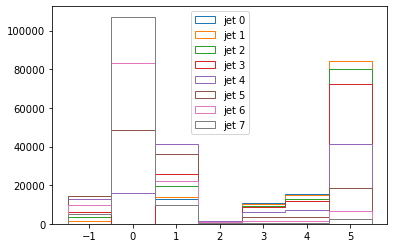

In [26]:
for i in range(0, nJetsMax):
    plt.hist(ggf.loc[ggf['nresolvedJets'] >= 4, f'j{i}_Db'],7,(-1.5,5.5),
             label=f'jet {i}',histtype='step')
plt.legend(loc='upper center')
plt.show()

**Question:** Does `df.resolved_nBTags` correspond to DL1r at the 77% WP?

In [31]:
# n77BTags = np.sum(ggf.loc[(ggf.resolved_nBTags>=2)&(ggf.nresolvedJets<=nJetsMax),[f'j{i}_Db' for i in range(nJetsMax)]] >= 3,axis=1)
# (n77BTagsTags)

So it looks like the answer is no - it's probably still MV2c10.

In [ ]:
X = df[myCols].values

In [ ]:
X.shape

**Step 2:** Model training

In [ ]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Layer, Masking, Input, Dense, Dropout, LSTM, concatenate, Multiply
from keras.layers import LSTMCell, GRU, GRUCell, Bidirectional, RNN, ReLU, BatchNormalization
from keras.layers import BatchNormalization, Embedding, Lambda, TimeDistributed, Softmax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [ ]:
class Sum(Layer):
    """
    Simple sum layer.
    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on their
    own.

    Author: Dan Guest
    https://github.com/dguest/flow-network/blob/master/SumLayer.py

    """

    def __init__(self, axis=1, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.keepdims = keepdims

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=self.axis, keepdims=self.keepdims)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [ ]:
class myModel():
    '''
    The basic base class for the models that I'm interested in training / comparing

    Should have the basic attributes for the LSTM, and the optimizer / fitting functions

    '''

    def __init__(self, timeSteps=15, nFeatures=5, loadModel=False, modelDir='models', dataTag=""):
        '''

        '''

        print("Initialize method from myModel()")

        self.timeSteps = timeSteps
        self.nFeatures = nFeatures
        self.loadModel = loadModel
        self.modelDir = modelDir
        self.dataTag = dataTag
        self.modelName = "please_overwrite_me"
        self.doEmbedding = False

        # Attibutes that should be overwritten in the children classes
        self.model = None
        self.hist = None
        self.monitor = None
        self.save_weights_only = None

    def createModel(self):
        '''
        This method will be implemented by the children inheriting from this class
        '''
        pass

    def train(self, X_train, y_train_cat, weights_train, CV_split=0.2,
              nEpochs=50, loss_weights=None):
        '''
        Define the optimizer and train the model.

        It saves the best model to an hdf5 file specified by the self.modelName attribute.
        (Ideally, it would also be able to load in models to continue a previous training -
         still need to implement this)

        Inputs:
            X_train, y_train_cat: Inputs and truth labels (as one-hot vectors) for the train set
            weights_train: The sample weights from the pT reweighting
            CV_split: The percent of the data to hold out for the validation curves
            nEpochs: number of epochs to train for

        '''

        # Check that the inputs have the correct dimensionality
        _, ts, nFeat = X_train.shape
        if ts != self.timeSteps or nFeat != self.nFeatures:
            print("Error: X_train does not have the correct dimensionality for the model.")
            return

        # Check that the model has been properly instantiated
        if self.model is None:
            print("Error: This function should not be called from parent class myModel().")
            return

        # Define the optimizer
        self.model.compile(loss='binary_crossentropy', optimizer='adam',
                           metrics=['binary_accuracy'], loss_weights=loss_weights)

        # Get the relevant inputs
        if self.doEmbedding:
            print("Training with the embedding layer")
            my_input = [X_train[:,:,:-1],X_train[:,:,-1]]
        else:
            my_input = X_train

        mTag = '_weights.h5' if self.save_weights_only else '.hdf5'
        mLoc =  '{}/{}{}'.format(self.modelDir,self.modelName,mTag)
        print('model checkpoint: {}'.format(mLoc))

        monitor = self.monitor
        verbose =0
        earlyStop = EarlyStopping(monitor=monitor, verbose=verbose, patience=10,restore_best_weights=True)
        mChkPt = ModelCheckpoint(mLoc,monitor=monitor, verbose=verbose,
                                 save_best_only=True,
                                 save_weights_only=self.save_weights_only)
        # Fit the model
        self.hist = self.model.fit(my_input, y_train_cat,
                                   epochs=nEpochs, batch_size=512, verbose=1,
                                   validation_split=CV_split,
                                   callbacks=[earlyStop, mChkPt],
                                   sample_weight=weights_train)

        # Save the history object as well
        h = h5py.File('{}/{}_history.hdf5'.format(self.modelDir, self.modelName), 'w')

        for key, val in self.hist.history.items():
            h.create_dataset(key, data=val)

        print("Saving history object")
        h.close()

    def eval(self, X):
        '''
        Do the preprocessing of the inputs here since
        with the embedding layer and the functional api, I need to pass
        the inputs as two separate streams
        '''
        if self.doEmbedding:
            return self.model.predict([X[:,:,:-1],X[:,:,-1]], batch_size=256, verbose=0)

        else:
            return self.model.predict(X, batch_size=256, verbose=0)


    def loadHistory(self):
        '''
        When you're retraining from a warm start, load in the previous training
        loss and accuracies and concatenate them with the new ones before saving
        the final history object.
        '''

        g = h5py.File("{}/{}_history.hdf5".format(self.modelDir, self.modelName),"r")

        loss     = g['loss'][:]
        val_loss = g['val_loss'][:]
        acc      = g['acc'][:]
        val_acc  = g['val_acc'][:]

        return loss, val_loss, acc, val_acc

    def processInputs(self):
        '''
        Process the separate trk stream inputs when doing the grade embedding
        '''
        cts_inputs = Input(shape=(self.timeSteps,self.nFeatures-1),name="Continuous_inputs")
        masked_input = Masking()(cts_trk_inputs)

        # Next look at a 2d embedding layer
        grade_input = Input(shape=(self.timeSteps,),name="Categorical_inputs", dtype='int32')
        embed = Embedding(N_CATEGORIES+1,2,mask_zero=True,input_length=self.timeSteps)(grade_input)

        # Merge the two layers
        myMerge = concatenate([masked_input, embed])

        trkEmbeddedInputs = Model(inputs=[cts_trk_inputs,grade_input],outputs=myMerge)
        return trkEmbeddedInputs

In [ ]:
class DeepSet(myModel):

    def __init__(self, ppm_sizes, dense_sizes, timeSteps=15, nFeatures=5, loadModel=False, 
                 modelDir='models', dataTag="",modelName="",batch_norm=True,
                 weightFile='',modelTag=''):
        myModel.__init__(self, timeSteps, nFeatures, loadModel, modelDir, dataTag)
        '''
        Goal: Patrick's EnergyFlow network was nice, but we really want something
        that is easier to plug into LWTNN, and that is more transparent for the
        different experiments that we want to run.

        Dan Guest shared a repo with me where he made a Keras custom sum layer,
        and showed how to implement a minimal working dataset that I just need
        to modify for my framework.

        https://github.com/dguest/flow-network/blob/master/train_nn.py

        '''

        if len(modelName) == 0:

            phiTag =  "_".join([str(x) for x in ppm_sizes])
            FTag   =  "_".join([str(x) for x in dense_sizes])
            bnTag = "_bn" if batch_norm else ""

            self.modelName = 'prodClass_phi_{}_F_{}{}_{}{}'.format(phiTag,FTag,bnTag,dataTag,modelTag)

        else:
            self.modelName = modelName

        self.monitor = 'val_loss'
        self.save_weights_only = True

        trk_inputs = Input(shape=(timeSteps,nFeatures))
        masked_inputs = Masking(mask_value=0)(trk_inputs)
        tdd = masked_inputs

        for i, phi_nodes in enumerate(ppm_sizes):

            tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
            if batch_norm:
                tdd = TimeDistributed(BatchNormalization(),name="Phi{}_BatchNormalization".format(i))(tdd)
            tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)
        
        # This is where the magic happens... sum up the track features!
        F = Sum()(tdd)

        for j, F_nodes in enumerate(dense_sizes):

            F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
            if batch_norm:
                F = BatchNormalization(name="F{}_BatchNormalization".format(j))(F)
            F = ReLU(name="F{}_ReLU".format(j))(F)

        output = Dense(1, activation='softmax',name="Jet_class")(F)
        self.model = Model(inputs=trk_inputs, outputs=output)

        modelLoc = '{}/{}.hdf5'.format(modelDir,self.modelName)
        if len(weightFile) == 0:
            weightFile = modelDir + "/" + self.modelName + "_weights.h5"
        print("weightFile",weightFile)
        if self.loadModel and os.path.isfile(weightFile):
            print("Loading previously trained DIPS weight file")
            self.model.load_weights(weightFile)
        else:
            print('Starting from new weight initialization')

In [ ]:
ppm_sizes = [50,50]
dense_sizes = [50,50]
_, timeSteps, nFeatures = X_tr.shape

dataTag = 'MAR20.2_MNT_ggf_vs_c2v1'

m = DeepSet(ppm_sizes=ppm_sizes, dense_sizes=dense_sizes, 
            timeSteps=timeSteps, loadModel=False, modelDir='models',
            nFeatures=nFeatures, dataTag=dataTag) 

print(m.model.summary())

In [ ]:
start = time.time()
m.train(X_tr, y_tr, w_tr, nEpochs=1)
end = time.time()

print("Successfully trained model!")
print("Training time: {:.0f} min".format((end-start)/60))

**Step 3:** Performance evaluation

I think the biggest thing to check here is implement an analysis chain, and compare $\Delta \eta_{hh}$ vs this NN roc curves.

**ggF selection**
- 4 leading b-jets with DL1r 77% WP
- MDR + min $D_{hh}$
- MD$p_T$
- $\Delta \eta_{hh}$
- $X_{wt}$
- kinematic_regions

Since for training we were only considering 4b events, I *don't* need to worry about this first cut, and can simply take the four leading jets rn.

In [ ]:
ggf

In [32]:
vs = ['pt','eta','phi','E']

j0 = TLorentzVectorArray.from_ptetaphi(*[ggf[f'j0_{v}'].values for v in vs])
j1 = TLorentzVectorArray.from_ptetaphi(*[ggf[f'j1_{v}'].values for v in vs])
j2 = TLorentzVectorArray.from_ptetaphi(*[ggf[f'j2_{v}'].values for v in vs])
j3 = TLorentzVectorArray.from_ptetaphi(*[ggf[f'j3_{v}'].values for v in vs])

In [ ]:
hc1s = j0+j1

hc2s = j2+j3

In [ ]:
x1s = np.where(j0.pt+j1.pt > j2.pt+j3.pt, j0+j1, j2+j3)

In [ ]:
hc1s

In [ ]:
hc2s[j0.pt+j1.pt > j2.pt+j3.pt].shape

In [ ]:
hc2s = hc2s.copy()

In [ ]:
hc2s.eta

In [ ]:
hc2s.pt

In [ ]:
mask = (j0.pt+j1.pt < j2.pt+j3.pt)

In [ ]:
mask

In [ ]:
len(ggf.index)

In [ ]:
j0.delta_r(j1)

In [62]:
def allPairs(df):
    '''
    Create HCs for the three combinations for the selected jets.

    Inputs:
    - df: The ...
    '''

    # For 4 jets, we have 3 pairings
    
    vs = ['pt','eta','phi','E']

    j0 = TLorentzVectorArray.from_ptetaphi(*[df[f'j0_{v}'].values for v in vs])
    j1 = TLorentzVectorArray.from_ptetaphi(*[df[f'j1_{v}'].values for v in vs])
    j2 = TLorentzVectorArray.from_ptetaphi(*[df[f'j2_{v}'].values for v in vs])
    j3 = TLorentzVectorArray.from_ptetaphi(*[df[f'j3_{v}'].values for v in vs])
    
    ps = [j0, j1, j2, j3]
    
    df['m4j'] = (j0+j1+j2+j3).mass
    
    for pi, (i11,i12), (i21,i22) in zip(range(3), [(0,1),(0,2),(0,3)], [(2,3),(1,3),(1,2)]):
    
        j11, j12 = ps[i11], ps[i12]
        j21, j22 = ps[i21], ps[i22]
    
        hc1s = j11 + j12 # j0 + j1
        hc2s = j21 + j22 # j2 + j3

        # Sort HCs by the scalar sum of the jet pTs
        mask = (j11.pt + j12.pt > j21.pt + j22.pt)

        df[f'pair{pi}_HC1_dRjj'] = np.where(mask, j11.delta_r(j12), j21.delta_r(j22))
        df[f'pair{pi}_HC2_dRjj'] = np.where(mask, j21.delta_r(j12), j22.delta_r(j22))
    
        # Save eta, pt and m as well
        for hci, m in zip([1,2], [mask,~mask]): 
            df[f'pair{pi}_HC{hci}_pt']  = np.where(m, hc1s.pt,  hc2s.pt)
            df[f'pair{pi}_HC{hci}_eta'] = np.where(m, hc1s.eta, hc2s.eta)
            df[f'pair{pi}_HC{hci}_phi'] = np.where(m, hc1s.phi, hc2s.phi)
            df[f'pair{pi}_HC{hci}_m']   = np.where(m, hc1s.mass,hc2s.mass)


In [63]:
allPairs(ggf)

In [64]:
allPairs(vbf)

In [65]:
from root_preprocess import lead_dRjj_cut,subl_dRjj_cut

In [66]:
def MDR(df):
    '''
    '''
    
    lead_dR_arr = df[[f'pair{pi}_HC1_dRjj' for pi in range(3)]]
    subl_dR_arr = df[[f'pair{pi}_HC2_dRjj' for pi in range(3)]]
    
    lead_pair_mask = lead_dRjj_cut(lead_dR_arr, df.m4j.values.reshape(-1,1))
    subl_pair_mask = subl_dRjj_cut(subl_dR_arr, df.m4j.values.reshape(-1,1))
    pair_mask = lead_pair_mask & subl_pair_mask
    
    nValidPairs = pair_mask.sum(axis=-1)

    df['nValidPairs'] = nValidPairs

    return pair_mask

In [67]:
ggf_pair_mask = MDR(ggf)
vbf_pair_mask = MDR(vbf)

In [39]:
np.sum(ggf.loc[ggf.nValidPairs!=0,'mc_sf'])/ggf['mc_sf'].sum()

0.15986077528140544

Ok - I think the acceptance of MDR is lower than what I saw before b/c I lowered the jet $p_T$ cut for the Deep Sets training.

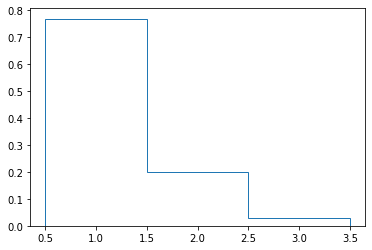

In [40]:
plt.hist(ggf.nValidPairs[ggf.nValidPairs!=0],3,(0.5,3.5),histtype='step',
         density=True,weights=ggf.loc[ggf.nValidPairs!=0,'mc_sf'])

plt.show()

In [ ]:
df = ggf

**Next:** min $D_{hh}$

In [ ]:
pair_mask = 

In [ ]:
df['chosenPair'] = -1

In [ ]:
pair_mask.shape

In [ ]:
mask = (df.nValidPairs == 2)

In [ ]:
df.loc[mask,[f'pair{pi}_HC1_eta' for pi in range(3)]].values[pair_mask[mask]]

In [ ]:
np.sum(mask)

In [ ]:
df.loc[mask,[f'pair{pi}_HC1_eta' for pi in range(3)]].values[pair_mask[mask]].reshape(-1,2).shape

In [ ]:
pair_mask[mask]

In [ ]:
Dhhs[mask]

In [ ]:
Dhhs[mask][pair_mask[mask]].reshape(-1,2)

In [ ]:
i = np.argmin(Dhhs[mask][pair_mask[mask]].reshape(-1,2),axis=-1)

In [ ]:
i

In [ ]:
m1s[mask]

In [ ]:
m1s[mask][pair_mask[mask]].reshape(-1,2)#[np.newaxis,i].shape

In [ ]:
?np.unravel_index()

In [ ]:
i = np.argmin(Dhhs[mask][pair_mask[mask]].reshape(-1,2),axis=-1)

In [ ]:
s = 120 / 100

m1s = df[[f'pair{i}_HC1_m' for i in range(3)]].values
m2s = df[[f'pair{i}_HC2_m' for i in range(3)]].values

Dhhs = np.abs(m1s - s * m2s) / np.sqrt(1+s**2)

In [ ]:
Dhhs.shape

In [ ]:
m1s[mask][pair_mask[mask]].reshape(-1,2).shape

In [ ]:
m1s[mask][pair_mask[mask]].reshape(-1,2)

In [ ]:
i

In [ ]:
m1s[mask][pair_mask[mask]].reshape(-1,2)[np.arange(np.sum(mask)),i]

In [41]:
def minDhh(df, pair_mask):
    '''
    Calculate Dhh for the valid pairs in the event

    Inputs:
    - df: A  reference to the df we're modifying
    - pair_mask: Boolean mask of whether or not each pairing passed the MDR cut

    '''

    s = 120 / 100
    m1s = df[[f'pair{i}_HC1_m' for i in range(3)]].values
    m2s = df[[f'pair{i}_HC2_m' for i in range(3)]].values

    Dhhs = np.abs(m1s - s * m2s) / np.sqrt(1+s**2)

    for nValidPairs in [1,2,3]:
    
        mask = (df.nValidPairs == nValidPairs)
        N = np.sum(mask)

        i = np.argmin(Dhhs[mask][pair_mask[mask]].reshape(-1,nValidPairs),axis=-1)

        for hci in [1,2]:
            df.loc[mask,f'HC{hci}_pt']  = df.loc[mask,[f'pair{pi}_HC{hci}_pt'  for pi in range(3)]].values\
                                            [pair_mask[mask]].reshape(-1,nValidPairs)[np.arange(N),i]
            df.loc[mask,f'HC{hci}_eta'] = df.loc[mask,[f'pair{pi}_HC{hci}_eta' for pi in range(3)]].values\
                                            [pair_mask[mask]].reshape(-1,nValidPairs)[np.arange(N),i]
            df.loc[mask,f'HC{hci}_phi'] = df.loc[mask,[f'pair{pi}_HC{hci}_phi' for pi in range(3)]].values\
                                            [pair_mask[mask]].reshape(-1,nValidPairs)[np.arange(N),i]
            df.loc[mask,f'HC{hci}_m']   = df.loc[mask,[f'pair{pi}_HC{hci}_m'    for pi in range(3)]].values\
                                            [pair_mask[mask]].reshape(-1,nValidPairs)[np.arange(np.sum(mask)),i]


In [42]:
minDhh(ggf, ggf_pair_mask)
minDhh(vbf, vbf_pair_mask)

What's next?

In [44]:
ggf.columns

Index(['eventNumber', 'nresolvedJets', 'resolved_nBTags', 'mcEventWeight',
       'weight_pileup', 'rand_run_nr', 'j0_pt', 'j0_eta', 'j0_phi', 'j0_E',
       'j0_Db', 'j0_sf', 'j1_pt', 'j1_eta', 'j1_phi', 'j1_E', 'j1_Db', 'j1_sf',
       'j2_pt', 'j2_eta', 'j2_phi', 'j2_E', 'j2_Db', 'j2_sf', 'j3_pt',
       'j3_eta', 'j3_phi', 'j3_E', 'j3_Db', 'j3_sf', 'j4_pt', 'j4_eta',
       'j4_phi', 'j4_E', 'j4_Db', 'j4_sf', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_E',
       'j5_Db', 'j5_sf', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_E', 'j6_Db', 'j6_sf',
       'j7_pt', 'j7_eta', 'j7_phi', 'j7_E', 'j7_Db', 'j7_sf',
       'HLT_2j35_bmv2c2060_split_2j35_L14J15.0ETA25',
       'HLT_j100_2j55_bmv2c2060_split', 'HLT_j225_bmv2c2060_split', 'trigger',
       'mc_sf', 'ntag', 'm4j', 'pair0_HC1_dRjj', 'pair0_HC2_dRjj',
       'pair0_HC1_eta', 'pair0_HC1_pt', 'pair0_HC1_m', 'pair0_HC2_eta',
       'pair0_HC2_pt', 'pair0_HC2_m', 'pair1_HC1_dRjj', 'pair1_HC2_dRjj',
       'pair1_HC1_eta', 'pair1_HC1_pt', 'pair1_HC1_m', 'pa

In [45]:
from analysis import getXwt, getXhh

In [ ]:
def analysisCuts(df):
    '''
    '''
    
    df['lead_pt'] = np.where(df.HC1_pt>df.HC2_pt, df.HC1_pt, df.HC2_pt)
    df['subl_pt'] = np.where(df.HC1_pt<df.HC2_pt, df.HC1_pt, df.HC2pt)
    df['deta_hh'] = np.abs(df.HC1_eta - df.HC2_eta)
    
    lead_pT_cut = 0.513333 * df['m4j'] - 103.3333
    subl_pT_cut = 0.33333 * df['m4j'] -  73.3333
    df['MDpT'] = (df['lead_pt'] > lead_pT_cut) & (df['subl_pt'] > subl_pT_cut) & miniNtuple['MDR']

    df['cut_deta_hh'] = (df['deta_hh'] < 1.5) & df['MDpT']
    
    df['Xwt'] = getXwt([j0,j1,j2,j3])
    
#     df['Xhh'] = getXhh(HC1, HC2)
#     

**Step 4:** Implementation of the rest of the analysis

- MD$p_T$
- $\Delta \eta_{hh}$
- kinematic regions

I think the main goal here is to compare w/r.t. the $\Delta \eta_{hh}$ cut.

**VBF analysis** 

I think atm the biggest difference between the analyses is that they've switced over to now selecting the initial scatter jets *first* as the two non-b jets with the *highest* $\Delta m_{jj}$.

I think it's probably fine for my preliminary study to just consider the leading 8 jets in the event?

In [79]:
# def processDf(filename,treename="XhhMiniNtuple",nJetsMax=8,nTagMin=4,year=2016):
#     '''
#     Given an input MNT, get the relevant jet features and apply the ml preprocessing

#     Inputs:
#     - filename
#     - treename
#     - nJetsMax
#     - nTagMin
#     - year: Year to apply the corresponding triggers for (default 2016)

#     Returns:

#     '''

# Open the file
print(f"\nOpening {vbf_filename}")
f = uproot.open(vbf_filename)
tree = f[treename]

print('Loading in the event df')
evt_vars = ['eventNumber', 'nresolvedJets','resolved_nBTags', 'mcEventWeight','weight_pileup','rand_run_nr']
df = tree.pandas.df(evt_vars)

# Get the jets
pre = 'resolvedJets'
jet_vars = [f'{pre}_{v}' for v in ['E','pt','phi','eta','is_DL1r_FixedCutBEff_77','Quantile_DL1r_Continuous','SF_DL1r_Continuous']]
jVars = ['pt','eta','phi','E','Db','sf']
myCols = [f'j{i}_{v}' for i in range(nJetsMax) for v in jVars]
for c in myCols:
    df[c] = 0

print('Loading in the jet array')
arr = tree.arrays(jet_vars)



Opening ../../public/hh4b/SMNR/user.jagrundy.HH4B.450052.VBF_nonres.MC16a-2015-2016.AB21.2.91-MAR20-0.full_MiniNTuple.root/user.jagrundy.20736311._000001.MiniNTuple.root
Loading in the event df
Loading in the jet array


In [80]:
for ntag in range(4,njet-2):
    print(ntag)

4
5
6
7
8
9
10


For implementing the rest of the analysis - need to select the relevant jets.

In [91]:
for njet in range(6,np.max(df.nresolvedJets)+1):

    # Need at least two IS jets
    for ntag in range(4,njet-1):
        
        mask = (df['nresolvedJets'] == njet) & (df['resolved_nBTags'] == ntag)
        
        if np.sum(mask) == 0:
            continue
        
        # hc jets - easiest: 4 leading in pT b-jets
        
        # IS jets - harder: need to form all possible combinations
        if (njet == 7) & (ntag ==4): 
            break
        
        
#         b_mask = mask & (df['resolved_nBTags'] == ntag)
#         non_b  = mask & (df['resolved_nBTags'] == ntag)
    
        #df.loc[mask,[f'j{i}_{v}' for i in range(njet)]] = arr[k][mask].flatten().reshape(-1,njet)
    

    
    
    

#     for v,w in zip(jVars[:5], jVars[:4]+['Quantile_DL1r_Continuous']):
#         k = f'resolvedJets_{w}'.encode()

#         if njet <= nJetsMax:
#             df.loc[mask,[f'j{i}_{v}' for i in range(njet)]] = arr[k][mask].flatten().reshape(-1,njet)
#         else:
#             df.loc[mask,[f'j{i}_{v}' for i in range(nJetsMax)]] = arr[k][mask].flatten().reshape(-1,njet)[:,:nJetsMax]

#     print(f'  Jet sfs for evts with {njet} jets')
#     sf_arr = np.array([[ci[0] for ci in c] for c in arr[f'{pre}_SF_DL1r_Continuous'.encode()][mask]])
#     N = min(njet, nJetsMax)
#     df.loc[mask,[f'j{i}_sf'  for i in range(N)]] = sf_arr if N < nJetsMax else sf_arr[:,:N] 

# # Apply 4 jets, b-tagger cuts
# df['ntag'] = np.sum(df[[f'j{i}_Db' for i in range(nJetsMax)]] >= 3,axis=1)



In [108]:
njet=7
mask = (df['nresolvedJets'] == njet) & (df['resolved_nBTags'] == 4)
        
N = np.sum(mask)
N

2036

In [128]:
np.max(df['nresolvedJets'])

14

In [115]:
bmask = arr[b'resolvedJets_is_DL1r_FixedCutBEff_77'][mask].flatten().reshape(-1,njet)
bmask

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 1, 1]], dtype=int32)

In [116]:
jpts = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1,njet)
jpts

array([[149.17125 , 149.47934 ,  82.376144, ...,  62.986404,  34.02458 ,
         27.122099],
       [134.57527 ,  83.43232 ,  58.45233 , ...,  43.188473,  40.700203,
         37.51565 ],
       [ 74.01356 ,  63.369984,  54.685238, ...,  42.31063 ,  37.697895,
         25.98274 ],
       ...,
       [338.1985  , 171.55807 , 103.281715, ...,  56.317112,  52.017475,
         36.06214 ],
       [143.81763 , 110.310745,  69.90575 , ...,  61.637314,  36.790695,
         35.424515],
       [114.46134 , 104.86743 ,  93.90502 , ...,  59.57113 ,  34.85932 ,
         34.265404]], dtype=float32)

In [117]:
jetas = arr[b'resolvedJets_eta'][mask].flatten().reshape(-1,njet)
jetas

array([[ 1.7491294 ,  0.9805323 , -0.55829084, ...,  0.24434036,
        -3.2357593 ,  2.9338162 ],
       [ 0.7030922 ,  1.6712234 , -0.07322976, ...,  1.4258959 ,
         1.2307698 , -1.0051533 ],
       [ 0.29852617, -0.70913327,  3.9126098 , ..., -2.030154  ,
        -3.389935  , -3.9139154 ],
       ...,
       [ 0.094213  , -2.3399458 ,  1.0256052 , ...,  1.2195542 ,
        -2.7657173 ,  0.972675  ],
       [ 0.07486944,  0.48069742,  0.17791966, ...,  0.08759323,
         2.6929872 , -1.0557978 ],
       [-2.0326881 , -1.1920705 , -0.6187834 , ...,  4.075987  ,
        -0.73766786,  0.68558866]], dtype=float32)

In [114]:
indices = np.tile(np.arange(njet), (N,1))
indices

array([[0, 1, 2, ..., 4, 5, 6],
       [0, 1, 2, ..., 4, 5, 6],
       [0, 1, 2, ..., 4, 5, 6],
       ...,
       [0, 1, 2, ..., 4, 5, 6],
       [0, 1, 2, ..., 4, 5, 6],
       [0, 1, 2, ..., 4, 5, 6]])

In [119]:
ctrl = (jpts > 40) & (np.abs(jetas) < 2.5)
fwd  = (jpts > 30) & (np.abs(jetas) > 2.5)

IS_candidates = (~bmask) & (ctrl | fwd)

In [123]:
IS_candidates

array([[1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0]], dtype=int32)

In [124]:
nISCand = np.sum(IS_candidates,axis=-1)

(array([  16.,    0.,    0.,  306.,    0.,    0., 1053.,    0.,    0.,
         661.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

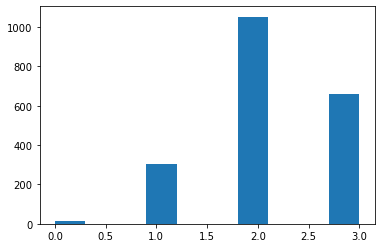

In [126]:
plt.hist(nISCand)

Alight - I think the next step is to loop over options for the number of IS candidates.

In [127]:
njet

7

In [ ]:
for nIS in range()

In [96]:
arr[k][mask].flatten().reshape(-1,njet)#.shape

array([[ 1,  5,  4, ...,  1,  1,  5],
       [ 5,  5, -1, ..., -1, -1,  5],
       [-1,  5,  4, ...,  4,  5, -1],
       ...,
       [ 3,  5, -1, ...,  5,  1, -1],
       [ 1,  5,  5, ...,  5, -1,  5],
       [ 1,  4,  5, ..., -1,  5,  5]], dtype=int32)

In [77]:
np.sum((df['resolved_nBTags'] != df['ntag'])&(df['nresolvedJets'] <= 8))

12

In [78]:
mask = (df['resolved_nBTags'] != df['ntag'])&(df['nresolvedJets'] <= 8)
df[mask]

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                               
14242        12231              2                1       0.003106   
27713        43555              3                2       0.003095   
28990         5929              3                2       0.003101   
30146         8360              3                3       0.003101   
32204         9273              3                1       0.003101   
40849        58979              3                2       0.003101   
50679        17263              3                1       0.003106   
56776        28671              3                2       0.003106   
65703        45366              3                2       0.003103   
66629        45738              3                1       0.003103   
68443        49907              3                1       0.003103   
71618        63737              3                2       0.003095   

       weight_pileup  rand_run_nr  j0_pt  j0_eta  j0_phi  j0_E  ...  j6_E  \
entry                                                           ...         
14242       1.032648       310249    0.0     0.0     0.0   0.0  ...   0.0   
27713       1.116819       280950    0.0     0.0     0.0   0.0  ...   0.0   
28990       1.257707       280950    0.0     0.0     0.0   0.0  ...   0.0   
30146       1.033192       303208    0.0     0.0     0.0   0.0  ...   0.0   
32204       1.070325       311287    0.0     0.0     0.0   0.0  ...   0.0   
40849       1.081683       306451    0.0     0.0     0.0   0.0  ...   0.0   
50679       1.032648       307454    0.0     0.0     0.0   0.0  ...   0.0   
56776       0.956132       310405    0.0     0.0     0.0   0.0  ...   0.0   
65703       1.145958       303421    0.0     0.0     0.0   0.0  ...   0.0   
66629       0.956132       304431    0.0     0.0     0.0   0.0  ...   0.0   
68443       1.008581       304178    0.0     0.0     0.0   0.0  ...   0.0   
71618       1.070325       300687    0.0     0.0     0.0   0.0  ...   0.0   

       j6_Db  j6_sf  j7_pt  j7_eta  j7_phi  j7_E  j7_Db  j7_sf  ntag  
entry                                                                 
14242      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
27713      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
28990      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
30146      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
32204      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
40849      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
50679      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
56776      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
65703      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
66629      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
68443      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  
71618      0    0.0    0.0     0.0     0.0   0.0      0    0.0     0  

[12 rows x 55 columns]

In [73]:
df[['nresolvedJets','resolved_nBTags','ntag']]

nresolvedJets  resolved_nBTags  ntag
entry                                      
0                  5                3     3
1                  7                2     2
2                  6                2     2
3                  7                2     2
4                  5                2     2
...              ...              ...   ...
74269              6                3     3
74270              5                3     3
74271              5                2     2
74272              5                3     3
74273              4                2     2

[74274 rows x 3 columns]

In [ ]:
def ISjets():
    '''
    Form the VBF combinations - and return the *best* possible scaling!
    '''
    
    

**Step 5: Open questions** 
- Should we apply additional weights to avoid learning the $m_{hh}$ spectrum?
- What kind of biases do we introduce by doing training on 4b instead of $\geq$ 2b?
- How does training on one $c_{2V}$ value compare to training on others?
- Should I have trained with SF information, and does it matter?
- Maybe I should use an embedding layer for the PC quantile score information?